<a href="https://colab.research.google.com/github/sharvaniyadav/Assignment-1-ECE1513-Intro-To-ML/blob/main/Assignment_1_ECE1513_IntroToML_SharvaniYadav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PART 1: CLUSTERING WITH K-MEANS

### 1. (5 points) Implement k-means yourself. Your function should take in an array containing a dataset and a value of k, and return the cluster centroids along with the cluster assignmentfor each data point. You may choose the centroid initialization heuristic of your choice among the two we saw in class. Hand-in the code for full credit. For this question, you should not rely on any library other than numPy in Python.

In [ ]:
# Course: ECE1513 Introduction to Machine Learning (Fall 2025)
# Assignment 1
# Student Name: Sharvani Yadav
# Student Number: 1008289870

# Part 1: Clustering with k-means
# This coded written below for Part 1 implements k-means clustering from scratch using only NumPy.
# It uses an initialization method discussed in class (sampled from the dataset).
# It will run the algorithm for k = 2..7, computes distortion, and plot an elbow curve.

# -------------------------------------------------------------------------------------------------
# Part 1.1: Implemented k-means using a single initialization method (sampling points from dataset)
# -------------------------------------------------------------------------------------------------

# Import needed libraries
# numpy: for math with arrays
# sklearn.datasets: to load the Breast Cancer dataset

# -----------------------------
# STEP 1: Loaded the dataset
# -----------------------------
from sklearn.datasets import load_breast_cancer

# Loading the UCI ML Breast Cancer dataset
data = load_breast_cancer()

# Only needed the features (X) for clustering, not the labels
X = data.data.astype(float)

print("=== DATASET LOADED ===")
print("Shape of X (rows, columns):", X.shape)   # should be 569 rows × 30 features
print("First row of raw data (before standardization):")
print(X[0])  # just to see the numbers before I change anything
print()

# -----------------------------
# STEP 2: Made all features the same scale (standardized)
# -----------------------------

# Imported NumPy for math operations
import numpy as np

# Found the average (mean) value for each feature
feature_means = X.mean(axis=0)

# Found how spread out (standard deviation) each feature was
feature_stds = X.std(axis=0, ddof=0)

# Replaced any feature with zero spread with 1 to avoid dividing by zero
feature_stds[feature_stds == 0] = 1.0

# Created a new dataset where each feature had mean 0 and spread ~1
# This was done by subtracting the mean and dividing by the standard deviation
Xs = (X - feature_means) / feature_stds

print("=== AFTER STANDARDIZATION ===")
print("First row after standardization (values were now near 0):")
print(np.round(Xs[0], 3))  # Rounded to make it easier to read

# Checked that the first few features had mean close to 0 and std close to 1
print("\nMean of first 5 features:", np.round(Xs[:, :5].mean(axis=0), 3))
print("Std of first 5 features:", np.round(Xs[:, :5].std(axis=0, ddof=0), 3))




=== DATASET LOADED ===
Shape of X (rows, columns): (569, 30)
First row of raw data (before standardization):
[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]

=== AFTER STANDARDIZATION ===
First row after standardization (values were now near 0):
[ 1.097 -2.073  1.27   0.984  1.568  3.284  2.653  2.532  2.218  2.256
  2.49  -0.565  2.833  2.488 -0.214  1.317  0.724  0.661  1.149  0.907
  1.887 -1.359  2.304  2.001  1.308  2.617  2.11   2.296  2.751  1.937]

Mean of first 5 features: [-0. -0. -0. -0.  0.]
Std of first 5 features: [1. 1. 1. 1. 1.]


In [ ]:
# ----------------------------------------------------
# STEP 3: Made the small functions needed for k-means
# ----------------------------------------------------

# Picked k starting points from the data to use as centroids
# Used a random seed so the results stayed the same every time the code ran
# (helpful so results match if the notebook is run again)
def init_centroids_from_data(X, k, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(X.shape[0], size=k, replace=False)
    return X[idx].copy()

# Found which centroid each data point was closest to
# First calculated the difference between each point and each centroid
# Then calculated the squared distance and picked the smallest one
# (squared distance was used because it's simpler and still works correctly)
def assign_labels(X, centroids):
    diff = X[:, None, :] - centroids[None, :, :]   # difference between points and centroids
    distances = np.sum(diff ** 2, axis=2)          # squared distances
    return np.argmin(distances, axis=1)            # index of closest centroid

# Moved each centroid to the middle (average) of all the points in its group
# If a group had no points, used the overall average of the data instead
# (this felt like the safest fallback so the algorithm wouldn't crash)
def recompute_centroids(X, labels, k):
    d = X.shape[1]
    new_centroids = np.empty((k, d), dtype=X.dtype)
    global_mean = X.mean(axis=0)
    for j in range(k):
        pts = X[labels == j]
        if pts.size > 0:
            new_centroids[j] = pts.mean(axis=0)
        else:
            new_centroids[j] = global_mean
    return new_centroids


In [ ]:
# -----------------------------
# STEP 4: Put the pieces together (full k-means)
# -----------------------------

# This function ran the whole k-means process.
# Simple idea: started with some centroids, then repeated:
#   1) gave each point the label of the closest centroid
#   2) moved each centroid to the average of its labeled points
# kept going until the centroids barely moved anymore
def kmeans(X, k, *, max_iter=300, tol=1e-4, seed=42):
    # Started with k centroids picked from the data (see Step 3)
    centroids = init_centroids_from_data(X, k, seed)

    # Looped up to max_iter times in case things took a while to settle
    for i in range(max_iter):
        # Step 1: Gave each point the label of its nearest centroid
        labels = assign_labels(X, centroids)

        # Step 2: Recomputed the centroids based on those labels
        new_centroids = recompute_centroids(X, labels, k)

        # Calculated how far the centroids moved since last time
        diff = new_centroids - centroids
        shift = np.linalg.norm(diff)

        # Updated centroids for the next round
        centroids = new_centroids

        # Added a check so the function could stop early
        # if the movement was smaller than the tolerance (means it settled)
        if shift < tol:
            break

    # Returned the final centroids and the label for every point
    return centroids, labels

In [ ]:
# -----------------------------
# STEP 5: Quick test run for Part 1.1
# -----------------------------

# Ran k-means with k=2 on the standardized data from Step 2
# (just to make sure the function from Step 4 worked)
centroids, labels = kmeans(Xs, k=2, max_iter=300, tol=1e-4, seed=42)

print("=== QUICK TEST RUN ===")
print("Centroids shape:", centroids.shape)  # should be (2, 30)
print("Labels shape:", labels.shape)        # should be (569,)
print("First 10 labels:", labels[:10])      # peek at first few cluster labels

=== QUICK TEST RUN ===
Centroids shape: (2, 30)
Labels shape: (569,)
First 10 labels: [1 1 1 1 1 1 1 1 1 1]


### 2. (1 point) Run the k-means algorithm for values of k varying between 2 and 7, at increments of 1. In your answer to this part, list the inputs passed to the k-means algorithm.

In [ ]:
# -------------------------------------------------------------------------
# Part 1.2: Ran k-means for k = 2 to 7 and listed inputs used for each run
# -------------------------------------------------------------------------

# -----------------------------------
# STEP 6: Ran k-means for k = 2 to 7
# -----------------------------------

# Looped over k values from 2 to 7 and ran k-means each time
# Printed the inputs used for each run to answer Part 1.2

for k in range(2, 8):  # goes through 2, 3, 4, 5, 6, 7
    print(f"\n✔ Running k-means with k = {k}")
    print("Inputs used:")
    print("  k =", k)
    print("  max_iter = 300")
    print("  tol = 1e-4")
    print("  seed = 42")

    # Ran k-means for this value of k
    centroids, labels = kmeans(Xs, k=k, max_iter=300, tol=1e-4, seed=42)

    # Printed quick summary to confirm it worked
    print("Centroids shape:", centroids.shape)
    print("Labels shape:", labels.shape)



✔ Running k-means with k = 2
Inputs used:
  k = 2
  max_iter = 300
  tol = 1e-4
  seed = 42
Centroids shape: (2, 30)
Labels shape: (569,)

✔ Running k-means with k = 3
Inputs used:
  k = 3
  max_iter = 300
  tol = 1e-4
  seed = 42
Centroids shape: (3, 30)
Labels shape: (569,)

✔ Running k-means with k = 4
Inputs used:
  k = 4
  max_iter = 300
  tol = 1e-4
  seed = 42
Centroids shape: (4, 30)
Labels shape: (569,)

✔ Running k-means with k = 5
Inputs used:
  k = 5
  max_iter = 300
  tol = 1e-4
  seed = 42
Centroids shape: (5, 30)
Labels shape: (569,)

✔ Running k-means with k = 6
Inputs used:
  k = 6
  max_iter = 300
  tol = 1e-4
  seed = 42
Centroids shape: (6, 30)
Labels shape: (569,)

✔ Running k-means with k = 7
Inputs used:
  k = 7
  max_iter = 300
  tol = 1e-4
  seed = 42
Centroids shape: (7, 30)
Labels shape: (569,)


### 3. (2 points) Plot the distortion achieved by k-means for values of k varying between 2 and 7, at increments of 1. Hand-in the code and figure output for full credit. For this question, you may rely on plotting libraries such as matplotlib.

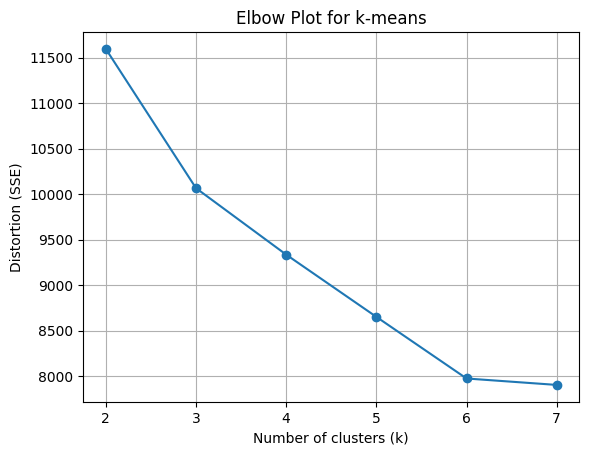

In [ ]:
# -------------------------------------------------------------------------
# Part 1.3: Plotted distortion for k = 2 to 7 (elbow curve)
# -------------------------------------------------------------------------

# -----------------------------------
# STEP 7: Computed and plotted distortion
# -----------------------------------

# Imported matplotlib for plotting
import matplotlib.pyplot as plt

# Made a list to save the distortions
distortions = []

# Tried k from 2 to 7 and calculated distortion for each one
for k in range(2, 8):
    # Ran k-means for this k value
    centroids, labels = kmeans(Xs, k=k, max_iter=300, tol=1e-4, seed=42)

    # Found how far each point was from its assigned centroid (squared distance)
    squared_distances = (Xs - centroids[labels]) ** 2

    # Added up all the squared distances to get total distortion
    sse = np.sum(squared_distances)
    distortions.append(sse)

# Plotted k on the x-axis and distortion on the y-axis
plt.plot([2, 3, 4, 5, 6, 7], distortions, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Distortion (SSE)")
plt.title("Elbow Plot for k-means")
plt.grid(True)
plt.show()

### 4. (1 point) If you had to pick one value of k, which value would you pick? Justify your choice.

After reviewing the elbow plot, the most appropriate choice of k is 6. The distortion decreases significantly from k=2 through k=4 and continues to decline for k=5 and k=6. Beyond k=6, the curve levels off and the reduction in distortion from k=6 to k=7 is minimal. This indicates that six clusters provide a strong balance between minimizing distortion and avoiding unnecessary model complexity.

## PART 4: EIGENVALUE INTERPRETATION VIA NORM MAXIMIZATION: IMPLEMENTATION

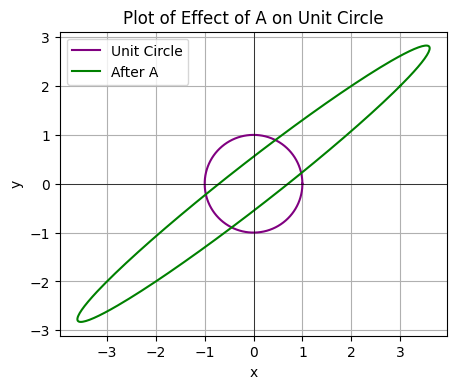

In [6]:
# -----------------------------------------------------------
# Part 4.1: Plotted the unit circle and its image under A
# -----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Made the matrix A
A = np.array([[3, 2], [2, 2]])

# Created 200 angles between 0 and 2π
angles = np.linspace(0, 2*np.pi, 200)

# Found x and y coordinates for points on the unit circle
x_points = np.cos(angles)
y_points = np.sin(angles)

# Combined x and y coordinates into (x, y) pairs
circle_points = np.column_stack((x_points, y_points))

# Multiplied each point by A to get its new location
transformed_points = np.dot(circle_points, A)

# Plotted the original unit circle and the transformed points with chosen colors
plt.figure(figsize=(5,5))
plt.plot(circle_points[:, 0], circle_points[:, 1], color="purple", label="Unit Circle")
plt.plot(transformed_points[:, 0], transformed_points[:, 1], color="green", label="After A")
plt.gca().set_aspect('equal', adjustable='box')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.title("Plot of Effect of A on Unit Circle")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()


The image of the unit circle under *A* was an ellipse. This shows that the matrix stretches and rotates the circle into an ellipse, with the longest axis in the direction of the eigenvector corresponding to the largest eigenvalue.

In [1]:
# -----------------------------------------------------------
# Part 4.2: Found the maximum value of ||A v|| and the v that reaches it
# -----------------------------------------------------------

import numpy as np

# Made the matrix A (used float numbers to be safe with division)
A = np.array([[3, 2], [2, 2]], dtype=float)

# Found the eigenvalues and eigenvectors of A
eigs, vecs = np.linalg.eig(A)

# Picked the index of the largest eigenvalue
largest_idx = np.argmax(eigs)

# Saved the largest eigenvalue (this was the maximum of ||A v|| for unit v)
max_val = eigs[largest_idx]

# Took the matching eigenvector (this was the direction that got stretched the most)
v_max = vecs[:, largest_idx]

# Turned that vector into a unit vector (length 1)
v_max = v_max / np.linalg.norm(v_max)

print("Maximum value of ||A v||:", max_val)
print("Unit vector v that achieves it:", v_max)

# Quick check: the length of A @ v_max should equal the maximum value
print("Check (||A v_max||):", np.linalg.norm(A @ v_max))


Maximum value of ||A v||: 4.561552812808831
Unit vector v that achieves it: [0.78820544 0.61541221]
Check (||A v_max||): 4.561552812808831


In [14]:
# -----------------------------------------------------------
# Part 4.3: Compared the biggest eigenvector with A * v
# -----------------------------------------------------------

import numpy as np

# Made the matrix A
A = np.array([[3, 2], [2, 2]], dtype=float)

# Found eigenvalues and eigenvectors
eigs, vecs = np.linalg.eig(A)

# Picked the biggest eigenvalue and its eigenvector
idx = np.argmax(eigs)
v_biggest = vecs[:, idx]

# Multiplied A by this eigenvector
Av_biggest = np.dot(A, v_biggest)

print("Eigenvalues:", eigs)
print("Eigenvectors (each column is a vector):")
print(vecs)

print("\nBiggest eigenvalue:", eigs[idx])
print("Eigenvector for biggest eigenvalue (unit vector):", v_biggest)

print("\nA * v_biggest =", Av_biggest)

# Printed both so it was easy to compare
print("\nCompare the two:")
print("v_biggest:", v_biggest)
print("A * v_biggest:", Av_biggest)
print("Observation: A * v_biggest points in the same direction as v_biggest (just longer).")


Eigenvalues: [4.56155281 0.43844719]
Eigenvectors (each column is a vector):
[[ 0.78820544 -0.61541221]
 [ 0.61541221  0.78820544]]

Biggest eigenvalue: 4.561552812808831
Eigenvector for biggest eigenvalue (unit vector): [0.78820544 0.61541221]

A * v_biggest = [3.59544073 2.80723529]

Compare the two:
v_biggest: [0.78820544 0.61541221]
A * v_biggest: [3.59544073 2.80723529]
Observation: A * v_biggest points in the same direction as v_biggest (just longer).


## PART 5: PCA FOR IMAGE DENOISING

Loading MNIST dataset...


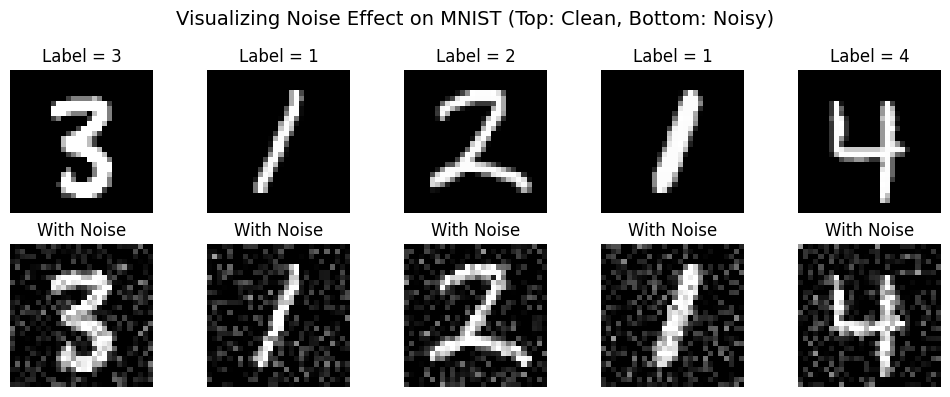

In [9]:
# -----------------------------------------------------------
# Part 5.1: Loaded MNIST, added noise, and showed 5 examples
# -----------------------------------------------------------

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Loaded the MNIST dataset (70,000 images, 28x28 pixels each)
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Broke out the image data (X) and labels (y)
X = mnist.data  # image pixels (each image is 784 numbers)
y = mnist.target.astype(int)  # digit labels from 0 to 9

# Step 2: Picked 5 random images from the dataset
rng = np.random.default_rng(42)  # fixed random number (answer to the universe :))
chosen_idx = rng.choice(X.shape[0], size=5, replace=False)

# Took the chosen images and reshaped them to 28x28 for plotting
chosen_images = X[chosen_idx].reshape(-1, 28, 28)
chosen_labels = y[chosen_idx]

# Step 3: Added random Gaussian noise (mean = 0, std = 50)
# This just makes the images look grainy
noise = rng.normal(loc=0, scale=50, size=chosen_images.shape)
noisy_images = chosen_images + noise

# Made sure pixel values stayed between 0 and 255 (valid range)
noisy_images = np.clip(noisy_images, 0, 255)

# Step 4: Plotted the images before and after adding noise
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(5):
    # Top row: original image
    axes[0, i].imshow(chosen_images[i], cmap="gray")
    axes[0, i].set_title(f"Label = {chosen_labels[i]}")
    axes[0, i].axis("off")

    # Bottom row: noisy image
    axes[1, i].imshow(noisy_images[i], cmap="gray")
    axes[1, i].set_title("With Noise")
    axes[1, i].axis("off")

plt.suptitle("Visualizing Noise Effect on MNIST (Top: Clean, Bottom: Noisy)", fontsize=14)
plt.tight_layout()
plt.show()
